# Kanal/Schachtdeckel-Erkennung


In [1]:
import pandas as pd
import numpy as np
import keras
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Flatten, Lambda, Cropping2D,Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("Kanaldeckel_dataset.csv")
X = dataset["image"]
y_train = dataset["type"]
X_train = [cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB) for i in X ]
print(len(X_train))
print(len(y_train))

1211
1211


## Data Augmentation

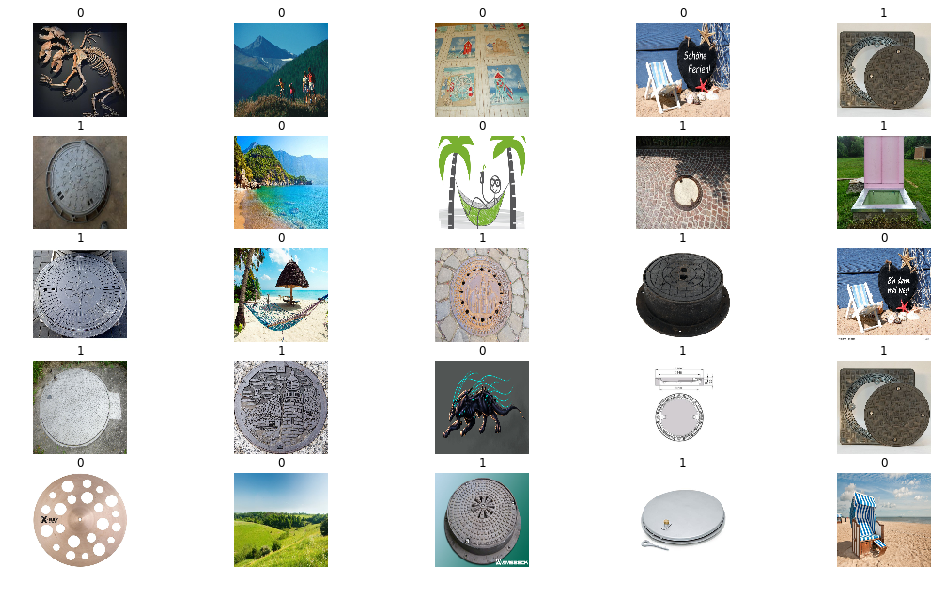

In [3]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig, axes = plt.subplots(5,5, figsize=(18, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()
for i in range(25):
    index = random.randint(0, len(X_train))
    img = X_train[index]
    axes[i].axis('off')
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title(y_train[index])



In [4]:
# Normalizing and grayscaling of the images
def grayscale(x):
    return np.sum(x/3, axis=3, keepdims=True)
def norm(x):
    return (x - 128)/128

In [5]:
X_train_c = np.copy(X_train)
X_train = norm(grayscale(X_train_c))

In [6]:
def random_translate(img):
    """
    Translates an Image in a random direction.
    Max-translation: 2 pixels in x,y direction.
    """
    #getting rows and cols
    r = 100
    c = 100
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)
    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(c,r))
    dst = dst[:,:,np.newaxis]
    
    return dst
def random_warp(img):
 
    #getting rows, cols form the input img
    r = 100
    c = 100
    #degree of warping
    degree = 0.09
    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= c * degree
    rndy = np.random.rand(3) - 0.5
    rndy *= r * degree
    # 3 starting points for transform, 1/4 way from edges
    x1 = c/4
    x2 = 3*c/4
    y1 = r/4
    y2 = 3*r/4

    pts1 = np.float32([[y1,x1],[y2,x1],[y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],[y2+rndy[1],x1+rndx[1]],[y1+rndy[2],x2+rndx[2]]])
    
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(c,r))   
    dst = dst[:,:,np.newaxis]   
    return dst
def random_zoom(img): 
    #getting rows, cols form the input img
    r = 100
    c = 100
    # zooming factor
    px = np.random.randint(-4,4)
    # ending locations
    pts1 = np.float32([[px,px],[r-px,px],[px,c-px],[r-px,c-px]])
    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[r,0],[0,c],[r,c]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(r,c))  
    dst = dst[:,:,np.newaxis]   
    return dst


In [7]:
test_img = (random_translate(random_zoom(random_warp(X_train[1]))))
print(len(X_train[1]))
print(X_train[1].shape)
print(len(test_img))
print(test_img.shape)

100
(100, 100, 1)
100
(100, 100, 1)


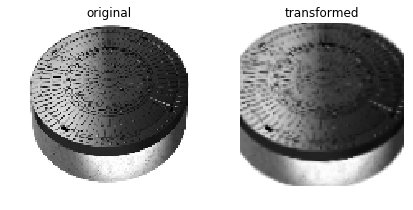

In [8]:
# Compare augmented an normal image
fig, axes = plt.subplots(1,2, figsize=(7, 3))
axes = axes.ravel()


axes[0].axis('off')
axes[0].set_title('original')
axes[0].imshow(X_train[1].squeeze(), cmap='gray')

axes[1].axis('off')
axes[1].set_title('transformed')
axes[1].imshow(test_img.squeeze(), cmap='gray')

#print("Shape gray Train-img: ", X_train_gry.shape,", ", "Mean: ", np.mean(X_train_gry))
#print("Shape normalized Train-img: ", X_train_norm.shape,", ", "Mean: ", np.mean(X_train_norm))

In [9]:
n_classes = 2
for i in range(n_classes):
    class_indices = np.where(y_train == i)
    n_samples = len(class_indices[0])
    if n_samples < 3000:
        for j in range(3000 - n_samples):
            new_img = X_train[class_indices[0][j % n_samples]]
            new_img = random_translate(random_zoom(random_warp(new_img)))
            #combining 
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [i]), axis=0)

print('X/y shapes after augmentation:', X_train.shape, y_train.shape)

X/y shapes after augmentation: (6000, 100, 100, 1) (6000,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

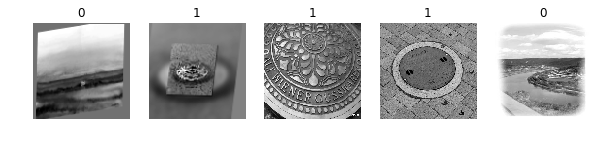

In [12]:
fig, axes = plt.subplots(1,5, figsize=(10, 8))
axes = axes.ravel()

axes[0].axis('off')
axes[0].set_title(y_train[1000])
axes[0].imshow(X_train[1000].squeeze(), cmap='gray')
axes[1].axis('off')
axes[1].set_title(y_train[1500])
axes[1].imshow(X_train[1500].squeeze(), cmap='gray')
axes[2].axis('off')
axes[2].set_title(y_train[2000])
axes[2].imshow(X_train[2000].squeeze(), cmap='gray')
axes[3].axis('off')
axes[3].set_title(y_train[2500])
axes[3].imshow(X_train[2500].squeeze(), cmap='gray')
axes[4].axis('off')
axes[4].set_title(y_train[3000])
axes[4].imshow(X_train[3000].squeeze(), cmap='gray')

In [13]:
model = Sequential()
model.add(Convolution2D(15, 5,activation = "relu",padding = "valid",data_format='channels_last', input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Convolution2D(45, 3,strides = 2, activation = "relu", padding= "valid",data_format='channels_last'))
model.add(Convolution2D(50, 3,strides = 2, activation = "relu", padding= "valid",data_format='channels_last'))
model.add(Convolution2D(55, 3, activation = "relu", padding= "valid",data_format='channels_last'))
model.add(Flatten())
model.add(Dense(40))
model.add(Dropout(0.4))
model.add(Dense(30))
model.add(Dropout(0.4))
model.add(Dense(20))
model.add(Dense(10))
model.add(Dense(1, activation = "sigmoid"))#"softmax"
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 15)        390       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 15)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 45)        6120      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 50)          20300     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 55)          24805     
_________________________________________________________________
flatten_1 (Flatten)          (None, 495)               0         
__________

Train on 4800 samples, validate on 1200 samples
Epoch 1/25
4800/4800 [==============================] - 1s - loss: 0.5923 - acc: 0.6915 - val_loss: 0.5162 - val_acc: 0.7658
Epoch 2/25
4800/4800 [==============================] - 0s - loss: 0.4569 - acc: 0.8121 - val_loss: 0.3974 - val_acc: 0.8367
Epoch 3/25
4800/4800 [==============================] - 0s - loss: 0.3633 - acc: 0.8540 - val_loss: 0.3185 - val_acc: 0.8792
Epoch 4/25
4800/4800 [==============================] - 0s - loss: 0.2418 - acc: 0.9048 - val_loss: 0.2312 - val_acc: 0.9125
Epoch 5/25
4800/4800 [==============================] - 0s - loss: 0.1703 - acc: 0.9425 - val_loss: 0.1995 - val_acc: 0.9333
Epoch 6/25
4800/4800 [==============================] - 0s - loss: 0.1542 - acc: 0.9398 - val_loss: 0.1734 - val_acc: 0.9483
Epoch 7/25
4800/4800 [==============================] - 0s - loss: 0.0782 - acc: 0.9731 - val_loss: 0.1952 - val_acc: 0.9442
Epoch 8/25
4800/4800 [==============================] - 0s - loss: 0.0610 - a

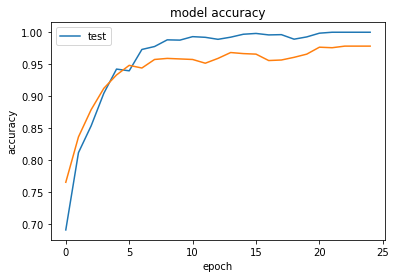

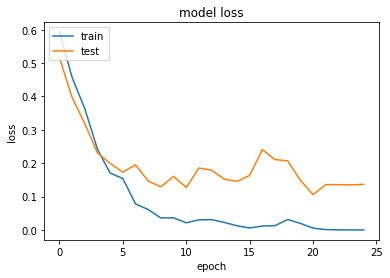

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, epochs = 25,batch_size = 124,validation_data=(X_test, y_test))
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
name = "Kanaldeckel.h5"
model.save(name)